## Importing the all the required libraries

In [3]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

## step-1: Load and Explore the Dataset

In [4]:
# Load and label the images from subdirectories
def load_images(image_dir, label_name):
    images = []
    labels = []
    
    # Traverse all files in the directory
    for subdir, _, files in os.walk(image_dir):
        for file_name in files:
            img_path = os.path.join(subdir, file_name)
            img = cv2.imread(img_path)

            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize to a common shape
                images.append(img)
                labels.append(label_name)  # Use the label name as a string
            else:
                print(f"Failed to load image: {img_path}")
    
    return np.array(images), np.array(labels)

# Set up your paths for training and testing data
train_dir_malignant = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\malignant'
train_dir_benign = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign'
test_dir_malignant = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\test\malignant'
test_dir_benign = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\test\benign'

# Load malignant and benign images for both train and test sets
X_train_malignant, y_train_malignant = load_images(train_dir_malignant, label_name="malignant")
X_train_benign, y_train_benign = load_images(train_dir_benign, label_name="benign")
X_test_malignant, y_test_malignant = load_images(test_dir_malignant, label_name="malignant")
X_test_benign, y_test_benign = load_images(test_dir_benign, label_name="benign")

# Combine malignant and benign images for train and test sets
X_train = np.concatenate((X_train_malignant, X_train_benign), axis=0)
y_train = np.concatenate((y_train_malignant, y_train_benign), axis=0)
X_test = np.concatenate((X_test_malignant, X_test_benign), axis=0)
y_test = np.concatenate((y_test_malignant, y_test_benign), axis=0)

print("Data Loaded Successfully!")


Data Loaded Successfully!


 ## Step-2: Knowing the  contents in the dataset

In [5]:
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Count the images in each folder
num_train_malignant = count_images_in_folder(train_dir_malignant)
num_train_benign = count_images_in_folder(train_dir_benign)
num_test_malignant = count_images_in_folder(test_dir_malignant)
num_test_benign = count_images_in_folder(test_dir_benign)

# Print the results
print(f"Number of malignant images in training set: {num_train_malignant}")
print(f"Number of benign images in training set: {num_train_benign}")
print("The total images in train dataset: ",(num_train_malignant + num_train_benign))
print(f"Number of malignant images in test set: {num_test_malignant}")
print(f"Number of benign images in test set: {num_test_benign}")
print("The total images in test dataset: ",(num_test_malignant + num_test_benign))

Number of malignant images in training set: 4605
Number of benign images in training set: 5000
The total images in train dataset:  9605
Number of malignant images in test set: 500
Number of benign images in test set: 500
The total images in test dataset:  1000


### Step-2.1: Class Distribution

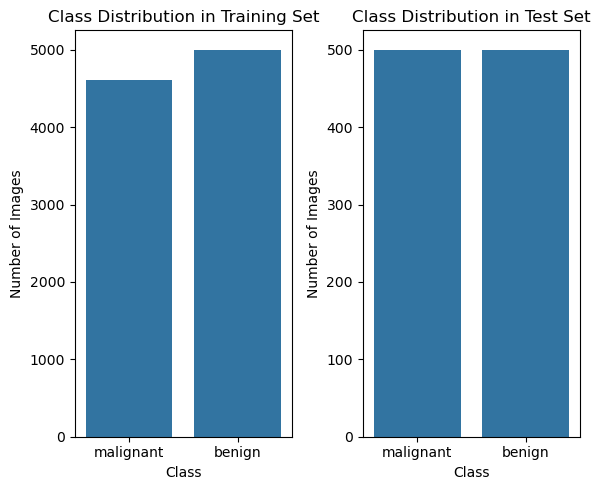

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_train and y_test are already defined as your target labels

# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(6, 5))  # Adjust figsize as needed

# Visualize the class distribution for the training set
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title('Class Distribution in Training Set')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')

# Visualize the class distribution for the test set
sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title('Class Distribution in Test Set')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



### Balancing our dataset can be important, especially if there is a significant imbalance between classes, as it can help improve model performance and prevent bias towards the majority class. Here's a breakdown of considerations based on your dataset:
### Understanding the Degree of Imbalance
### In our case, the training set has:
### 4,605 malignant images
### 5,000 benign images
### This is a relatively balanced dataset (the difference between the classes is not very large, just 395 images).
### there is no need to adjust it.

 ## Step-3: Handling Duplicated images

### Step-3.1:Finding Duplicated Images Whether exist or not

In [6]:
import imagehash
import os
from PIL import Image

# Define the paths to your train and test datasets
train_path = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train'
test_path = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\test'

# Function to find duplicates
def find_duplicates(image_dir):
    """Finds and prints duplicate images within a directory."""

    image_hashes = {}  # Store image hashes
    duplicates = []     # Store duplicate image paths

    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(image_dir, filename)
            try:
                with Image.open(img_path) as img:
                    hash = imagehash.phash(img)  # Calculate perceptual hash
                    if hash in image_hashes:
                        duplicates.append((image_hashes[hash], img_path))  # Store duplicate
                    else:
                        image_hashes[hash] = img_path  # Store unique hash
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    return duplicates

# --- Run duplicate detection ---
train_duplicates = []
test_duplicates = []

datasets = [
    (os.path.join(train_path, 'benign'), "train_benign"),
    (os.path.join(train_path, 'malignant'), "train_malignant"),
    (os.path.join(test_path, 'benign'), "test_benign"),
    (os.path.join(test_path, 'malignant'), "test_malignant")
]

for dataset_path, dataset_name in datasets:
    duplicates = find_duplicates(dataset_path)
    duplicate_count = len(duplicates)
    print(f"Number of duplicate images in {dataset_name}: {duplicate_count}")

    # Store duplicates in respective lists
    if 'train' in dataset_name:
        train_duplicates.extend(duplicates)
    elif 'test' in dataset_name:
        test_duplicates.extend(duplicates)

# Now, train_duplicates and test_duplicates contain the lists of duplicate pairs


Number of duplicate images in train_benign: 0
Number of duplicate images in train_malignant: 0
Number of duplicate images in test_benign: 0
Number of duplicate images in test_malignant: 0


### Step-3.2:Displaying Those Images

Duplicate Images in Training Dataset:


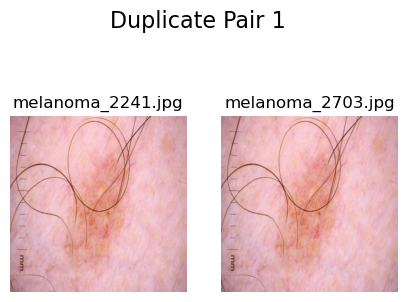

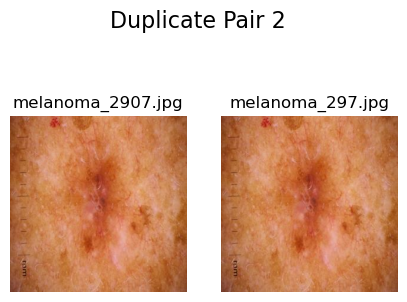

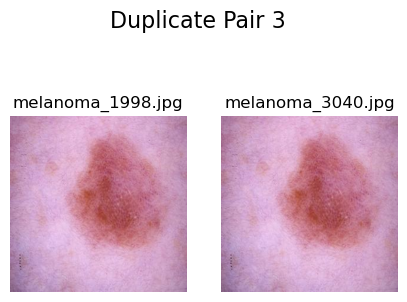

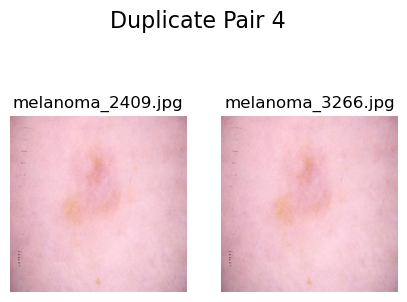

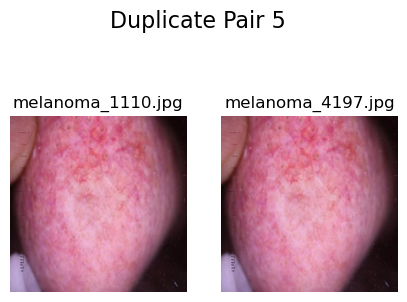

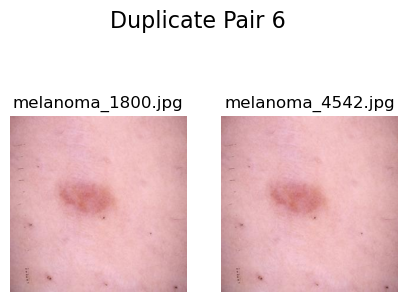

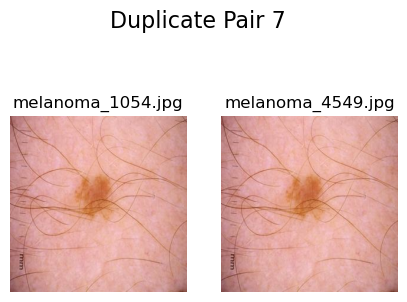

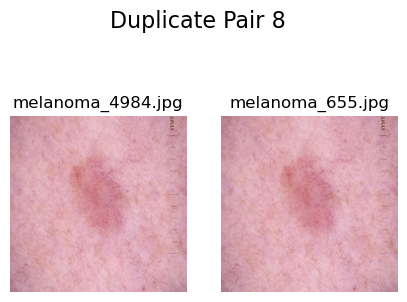

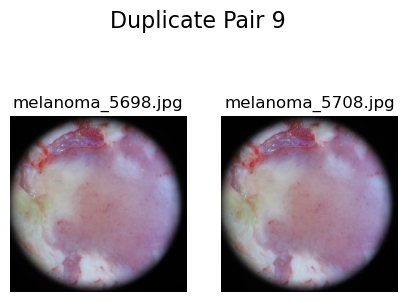

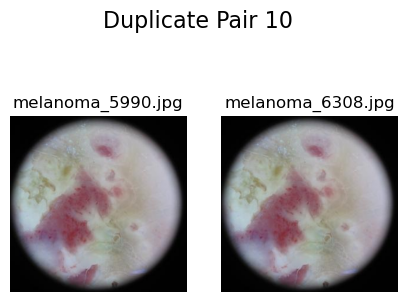

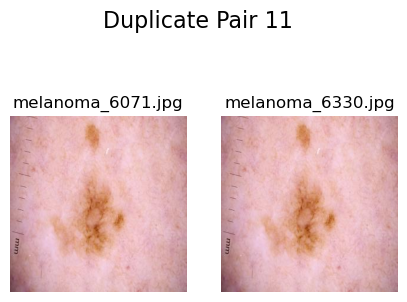

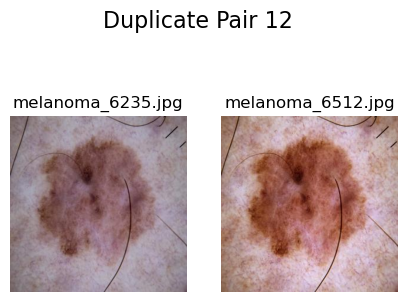

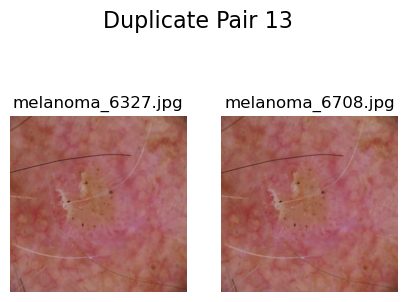

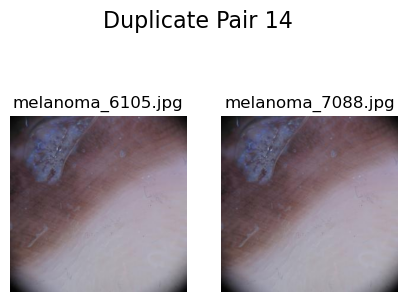

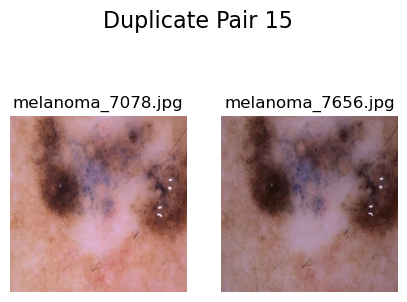

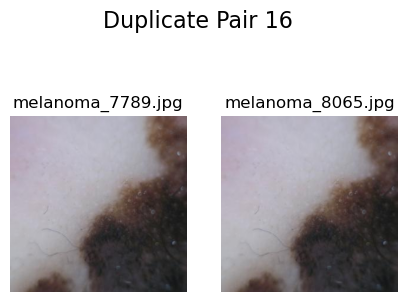

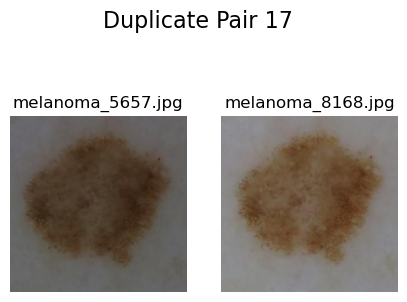

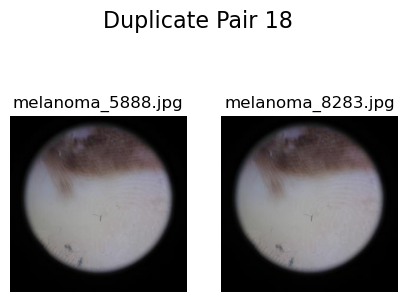

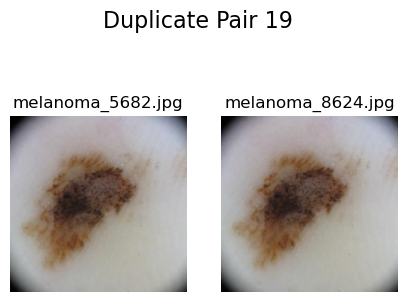

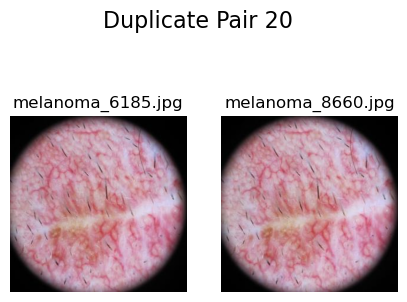

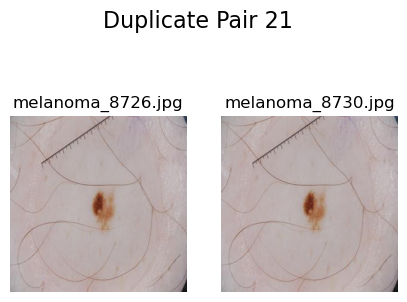

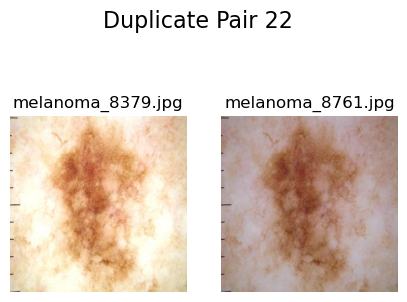

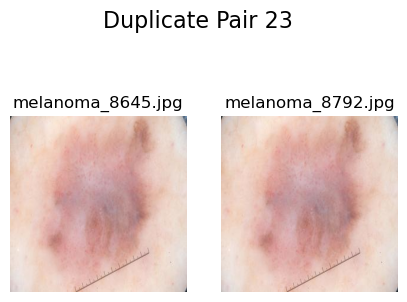

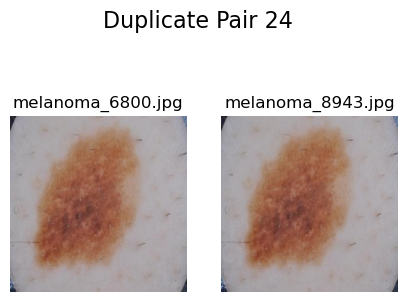

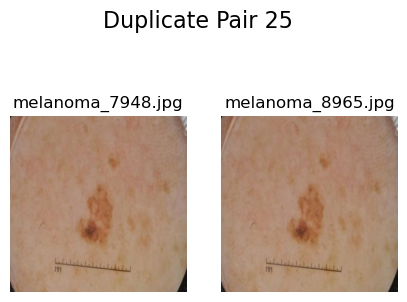

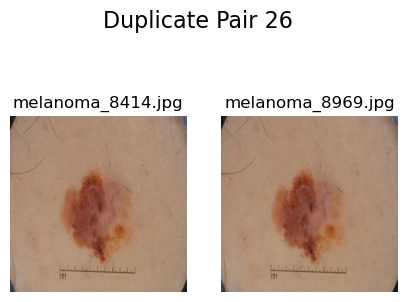


Duplicate Images in Testing Dataset:


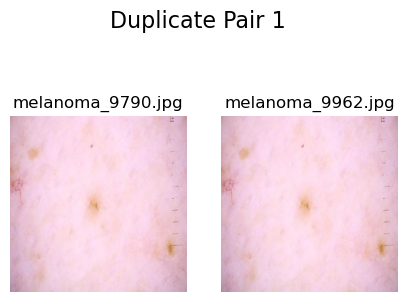

In [6]:
import matplotlib.pyplot as plt
import cv2
import os

def display_duplicates(duplicates):
    """Display each pair of duplicate images side-by-side with their filenames."""
    for idx, (img_path1, img_path2) in enumerate(duplicates, start=1):
        img1 = cv2.imread(img_path1)
        img2 = cv2.imread(img_path2)
        
        # Convert from BGR (OpenCV default) to RGB for displaying with matplotlib
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        
        # Extract the file names from paths
        img_name1 = os.path.basename(img_path1)
        img_name2 = os.path.basename(img_path2)
        
        # Plot the pair side-by-side
        plt.figure(figsize=(5, 4))
        plt.suptitle(f"Duplicate Pair {idx}", fontsize=16)
        
        # First image
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.title(img_name1)  # Use the filename as the title
        plt.axis('off')
        
        # Second image
        plt.subplot(1, 2, 2)
        plt.imshow(img2)
        plt.title(img_name2)  # Use the filename as the title
        plt.axis('off')
        
        plt.show()

# Assuming 'train_duplicates' and 'test_duplicates' are already defined
print("Duplicate Images in Training Dataset:")
display_duplicates(train_duplicates)  # Display training duplicates

print("\nDuplicate Images in Testing Dataset:")
display_duplicates(test_duplicates)  # Display testing duplicates


### Step-3.3: Removing Those Images

In [7]:
import os

def remove_duplicates(duplicates):
    """Remove the second image in each duplicate pair."""
    for _, img_path2 in duplicates:
        try:
            os.remove(img_path2)
            print(f"Removed duplicate: {img_path2}")
        except OSError as e:
            print(f"Error removing {img_path2}: {e}")

# Remove duplicates in the training and testing datasets
print("Removing duplicates in Training Dataset:")
remove_duplicates(train_duplicates)

print("\nRemoving duplicates in Testing Dataset:")
remove_duplicates(test_duplicates)


Removing duplicates in Training Dataset:
Removed duplicate: C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign\melanoma_2703.jpg
Removed duplicate: C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign\melanoma_297.jpg
Removed duplicate: C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign\melanoma_3040.jpg
Removed duplicate: C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign\melanoma_3266.jpg
Removed duplicate: C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign\melanoma_4197.jpg
Removed duplicate: C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign\melanoma_4542.jpg
Removed duplicate: C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign\melanoma_4549.jpg
Removed duplicate: C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign\melanoma_655.jpg
Removed duplicate: C:\Users\HP\Downloads\

### Step-3.4:Reverification whether those images are Removed or not

In [4]:
import imagehash
import os
from PIL import Image

# Define the paths to your train and test datasets
train_path = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train'
test_path = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\test'

def find_duplicates(image_dir):
    """Finds and prints duplicate images within a directory."""

    image_hashes = {}  # Store image hashes
    duplicates = []     # Store duplicate image paths

    for filename in os.listdir(image_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(image_dir, filename)
            try:
                with Image.open(img_path) as img:
                    hash = imagehash.phash(img)  # Calculate perceptual hash
                    if hash in image_hashes:
                        duplicates.append((image_hashes[hash], img_path))  # Store duplicate
                    else:
                        image_hashes[hash] = img_path  # Store unique hash
            except Exception as e:
                print(f"Error processing image: {img_path}, error: {e}")

    return duplicates

# --- Run duplicate detection ---
datasets = [
    (os.path.join(train_path, 'benign'), "train_benign"),
    (os.path.join(train_path, 'malignant'), "train_malignant"),
    (os.path.join(test_path, 'benign'), "test_benign"),
    (os.path.join(test_path, 'malignant'), "test_malignant")
]

for dataset_path, dataset_name in datasets:
    duplicates = find_duplicates(dataset_path)
    duplicate_count = len(duplicates)
    print(f"Number of duplicate images in {dataset_name}: {duplicate_count}")


Number of duplicate images in train_benign: 0
Number of duplicate images in train_malignant: 0
Number of duplicate images in test_benign: 0
Number of duplicate images in test_malignant: 0


### Step-3.5:Count of Images After removing Duplicated Images

In [9]:
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Count the images in each folder
num_train_malignant = count_images_in_folder(train_dir_malignant)
num_train_benign = count_images_in_folder(train_dir_benign)
num_test_malignant = count_images_in_folder(test_dir_malignant)
num_test_benign = count_images_in_folder(test_dir_benign)

# Print the results
print(f"Number of malignant images in training set: {num_train_malignant}")
print(f"Number of benign images in training set: {num_train_benign}")
print("The total images in train dataset: ",(num_train_malignant + num_train_benign))
print(f"Number of malignant images in test set: {num_test_malignant}")
print(f"Number of benign images in test set: {num_test_benign}")
print("The total images in test dataset: ",(num_test_malignant + num_test_benign))

Number of malignant images in training set: 4587
Number of benign images in training set: 4992
The total images in train dataset:  9579
Number of malignant images in test set: 500
Number of benign images in test set: 499
The total images in test dataset:  999


## number of images before removal duplicates:

 ##### Number of malignant images in training set: 4605
  ##### Number of benign images in training set: 5000
  ##### The total images in train dataset:  9605
  ##### Number of malignant images in test set: 500
  ##### Number of benign images in test set: 500
  ##### The total images in test dataset:  1000 '''

## Step-4:Displaying The Sample Images

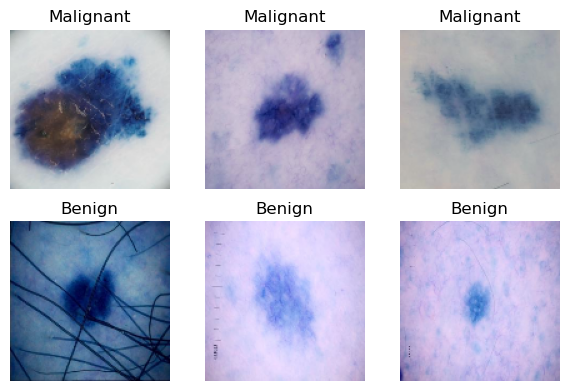

In [10]:
import matplotlib.pyplot as plt
import random

# Function to display random images from a specific class
def plot_random_images(X, y, class_labels, num_images=3):
    plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
    
    for j, class_label in enumerate(class_labels):
        # Select indices where the label matches the specified class_label
        class_indices = [i for i in range(len(y)) if y[i] == class_label]
        
        for i in range(num_images):
            plt.subplot(2, num_images, j * num_images + i + 1)  # 2 rows, num_images columns
            img_index = random.choice(class_indices)
            plt.imshow(X[img_index])
            plt.title(class_label.capitalize())  # Set title as "Malignant" or "Benign"
            plt.axis('off')
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Plot sample malignant and benign images with labels
plot_random_images(X_train, y_train, class_labels=["malignant", "benign"])


## Step-5 : Pixel Intensity Distribution

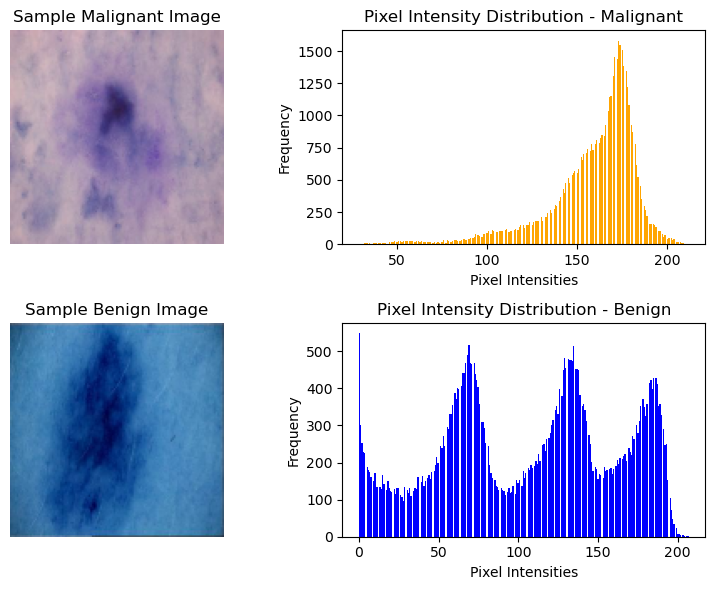

In [11]:
import matplotlib.pyplot as plt
import random

# Function to display a sample image and its pixel intensity distribution
def visualize_pixel_intensity(X, y, malignant_index, benign_index):
    # Determine the class labels of the selected images
    malignant_label = "malignant"
    benign_label = "benign"
    
    # Create a figure with 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    
    # Display the malignant image
    axes[0, 0].imshow(X[malignant_index])
    axes[0, 0].set_title(f'Sample Malignant Image')
    axes[0, 0].axis('off')  # Hide axes
    
    # Display the histogram for the malignant image
    axes[0, 1].hist(X[malignant_index].ravel(), bins=256, color='orange')
    axes[0, 1].set_xlabel('Pixel Intensities')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Pixel Intensity Distribution - Malignant')
    
    # Display the benign image
    axes[1, 0].imshow(X[benign_index])
    axes[1, 0].set_title(f'Sample Benign Image')
    axes[1, 0].axis('off')  # Hide axes
    
    # Display the histogram for the benign image
    axes[1, 1].hist(X[benign_index].ravel(), bins=256, color='blue')
    axes[1, 1].set_xlabel('Pixel Intensities')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Pixel Intensity Distribution - Benign')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Select random indices for malignant and benign images
malignant_index = random.choice([i for i in range(len(y_train)) if y_train[i] == "malignant"])
benign_index = random.choice([i for i in range(len(y_train)) if y_train[i] == "benign"])

# Visualize one malignant and one benign image with their pixel intensity distributions
visualize_pixel_intensity(X_train, y_train, malignant_index, benign_index)


## Step-6: Normalization: Convert the pixel values to the range [0, 1].

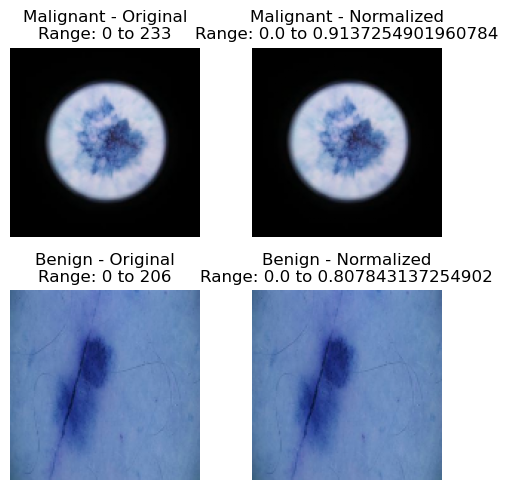

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Normalize all images in the dataset
X_train_normalized = np.array([img / 255.0 for img in X_train])
X_test_normalized = np.array([img / 255.0 for img in X_test])

# Function to display a sample malignant and benign image side-by-side before and after normalization
def visualize_sample_images(X_original, X_normalized, y):
    # Find indices for each class label
    malignant_index = random.choice([i for i in range(len(y)) if y[i] == "malignant"])
    benign_index = random.choice([i for i in range(len(y)) if y[i] == "benign"])
    
    # Get min and max pixel values to verify normalization
    original_mal_min, original_mal_max = X_original[malignant_index].min(), X_original[malignant_index].max()
    normalized_mal_min, normalized_mal_max = X_normalized[malignant_index].min(), X_normalized[malignant_index].max()
    original_ben_min, original_ben_max = X_original[benign_index].min(), X_original[benign_index].max()
    normalized_ben_min, normalized_ben_max = X_normalized[benign_index].min(), X_normalized[benign_index].max()
    
    # Set up the figure with smaller images side-by-side
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    
    # Display original malignant image
    axes[0, 0].imshow(X_original[malignant_index])
    axes[0, 0].set_title(f'Malignant - Original\nRange: {original_mal_min} to {original_mal_max}')
    axes[0, 0].axis('off')
    
    # Display normalized malignant image
    axes[0, 1].imshow(X_normalized[malignant_index])
    axes[0, 1].set_title(f'Malignant - Normalized\nRange: {normalized_mal_min} to {normalized_mal_max}')
    axes[0, 1].axis('off')
    
    # Display original benign image
    axes[1, 0].imshow(X_original[benign_index])
    axes[1, 0].set_title(f'Benign - Original\nRange: {original_ben_min} to {original_ben_max}')
    axes[1, 0].axis('off')
    
    # Display normalized benign image
    axes[1, 1].imshow(X_normalized[benign_index])
    axes[1, 1].set_title(f'Benign - Normalized\nRange: {normalized_ben_min} to {normalized_ben_max}')
    axes[1, 1].axis('off')
    
    # Adjust layout for compactness
    plt.tight_layout()
    plt.show()

# Visualize a sample malignant and benign image
visualize_sample_images(X_train, X_train_normalized, y_train)


## Making and Collecting all the Normalized Images and Saving in a New Folder (Normalized Images) 

In [ ]:
import os
from PIL import Image
import numpy as np

# Paths
root_dir = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
normalized_dir = r'C:\Users\HP\Downloads\Normalized_colour'

# Create the necessary directories if they don't exist
train_normalized_dir = os.path.join(normalized_dir, 'Train')
test_normalized_dir = os.path.join(normalized_dir, 'Test')

os.makedirs(train_normalized_dir, exist_ok=True)
os.makedirs(test_normalized_dir, exist_ok=True)

# Define subcategories: benign and malignant
subcategories = ['benign', 'malignant']

# Create subdirectories for 'benign' and 'malignant' under Train and Test
for subcategory in subcategories:
    os.makedirs(os.path.join(train_normalized_dir, subcategory), exist_ok=True)
    os.makedirs(os.path.join(test_normalized_dir, subcategory), exist_ok=True)

# Function to normalize and save images
def normalize_and_save_images(input_dir, output_dir):
    # Loop through benign and malignant directories
    for subcategory in subcategories:
        subcategory_dir = os.path.join(input_dir, subcategory)
        output_subcategory_dir = os.path.join(output_dir, subcategory)

        # Ensure the subcategory directory exists
        if not os.path.exists(subcategory_dir):
            continue
        
        # Loop through all the files in the subcategory directory
        for file in os.listdir(subcategory_dir):
            input_file = os.path.join(subcategory_dir, file)
            
            # Only process files (skip directories)
            if os.path.isdir(input_file):
                continue

            # Open the image
            img = Image.open(input_file)

            # Convert to numpy array and normalize (scale to [0, 1])
            img_array = np.array(img) / 255.0  # Normalize to range [0, 1]

            # Convert back to image (uint8 format)
            img_normalized = Image.fromarray((img_array * 255).astype(np.uint8))

            # Construct the output file path
            output_file = os.path.join(output_subcategory_dir, file)

            # Save the normalized image
            img_normalized.save(output_file)
            print(f"Saved normalized image: {output_file}")

# Normalize and save the train images
normalize_and_save_images(train_dir, train_normalized_dir)

# Normalize and save the test images
normalize_and_save_images(test_dir, test_normalized_dir)

print("Normalization complete!")


## Step-7: Outlier Detection (Corrupted Images)

In [13]:
# Check for corrupted images by comparing their shape
def check_image_shapes(images):
    shape_issues = []
    for i, img in enumerate(images):
        if img.shape != (128, 128, 3):  # Check if image has correct shape
            shape_issues.append(i)
    return shape_issues

# Check training images
train_shape_issues = check_image_shapes(X_train)
if len(train_shape_issues) > 0:
    print(f"Found {len(train_shape_issues)} images with shape issues in the training set.")
else:
    print("All training images are of consistent shape.")


All training images are of consistent shape.


## Step-8: Converting Images Into GrayScale

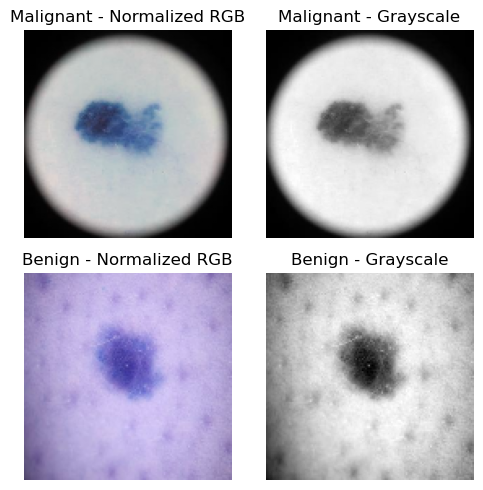

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage.color import rgb2gray

# Normalize all images in the dataset
X_train_normalized = np.array([img / 255.0 for img in X_train])

# Convert normalized images to grayscale
X_train_grayscale = np.array([rgb2gray(img) for img in X_train_normalized])

# Function to display a sample malignant and benign image, showing normalized RGB and grayscale side-by-side
def visualize_rgb_grayscale(X_normalized, X_grayscale, y):
    # Find indices for each class label
    malignant_index = random.choice([i for i in range(len(y)) if y[i] == "malignant"])
    benign_index = random.choice([i for i in range(len(y)) if y[i] == "benign"])
    
    # Set up the figure with a compact layout
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    
    # Display normalized RGB malignant image
    axes[0, 0].imshow(X_normalized[malignant_index])
    axes[0, 0].set_title('Malignant - Normalized RGB')
    axes[0, 0].axis('off')
    
    # Display grayscale malignant image
    axes[0, 1].imshow(X_grayscale[malignant_index], cmap='gray')
    axes[0, 1].set_title('Malignant - Grayscale')
    axes[0, 1].axis('off')
    
    # Display normalized RGB benign image
    axes[1, 0].imshow(X_normalized[benign_index])
    axes[1, 0].set_title('Benign - Normalized RGB')
    axes[1, 0].axis('off')
    
    # Display grayscale benign image
    axes[1, 1].imshow(X_grayscale[benign_index], cmap='gray')
    axes[1, 1].set_title('Benign - Grayscale')
    axes[1, 1].axis('off')
    
    # Adjust layout for compactness
    plt.tight_layout()
    plt.show()

# Visualize a sample malignant and benign image, showing normalized RGB and grayscale
visualize_rgb_grayscale(X_train_normalized, X_train_grayscale, y_train)


## Making all normalized RBG into Grey Scale and Collecting all the Images and Saving in a New Folder (Grey_Scale Images) 

In [ ]:
import os
from PIL import Image

def convert_images_to_grayscale(source_folder, destination_folder):
    # Walk through the source folder structure (train/test and then malignant/benign)
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            # Get the full path of the image
            source_image_path = os.path.join(root, file)
            
            # Open the image using PIL
            image = Image.open(source_image_path)
            
            # Convert the image to grayscale
            grayscale_image = image.convert('L')
            
            # Build the destination path, which mirrors the source structure
            relative_path = os.path.relpath(root, source_folder)
            destination_image_folder = os.path.join(destination_folder, relative_path)
            
            # Ensure the destination folder exists, create it if necessary
            os.makedirs(destination_image_folder, exist_ok=True)
            
            # Define the destination image path
            destination_image_path = os.path.join(destination_image_folder, file)
            
            # Save the grayscale image to the destination path
            grayscale_image.save(destination_image_path)
            print(f"Saved: {destination_image_path}")

# Define paths
source_folder = r'C:\Users\HP\Downloads\Normalized_colour'  # Path to your Normalized_colour folder
destination_folder = r'C:\Users\HP\Downloads\Grey_images'  # Path to save the Grey_images folder

# Convert images
convert_images_to_grayscale(source_folder, destination_folder)


## Step-9:Pixel Intensity Distribution Comparision Between Normalized RGB and GrayScale

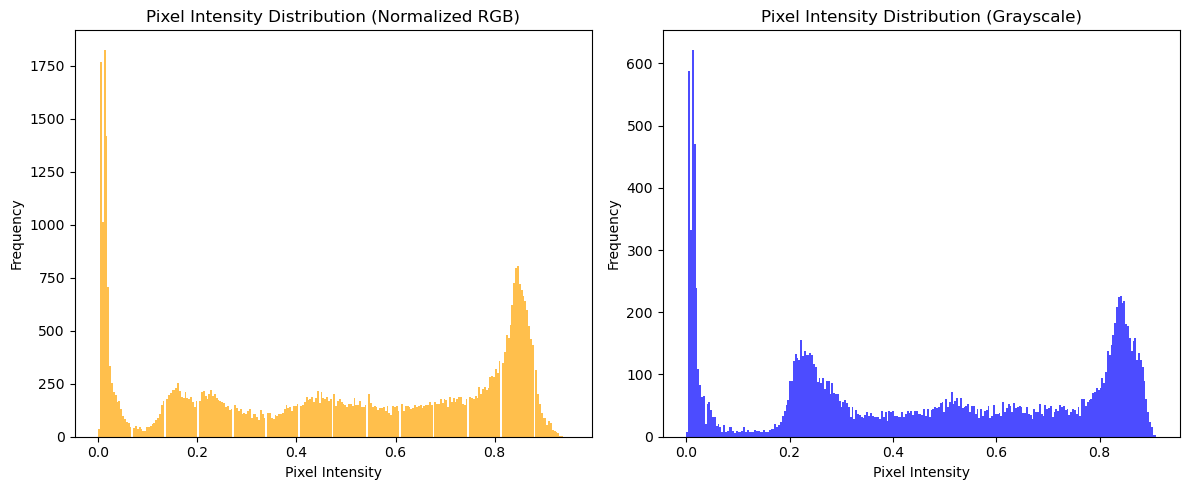

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import random
from skimage.color import rgb2gray

# Normalize all images in the dataset
X_train_normalized = np.array([img / 255.0 for img in X_train])

# Convert normalized images to grayscale
X_train_grayscale = np.array([rgb2gray(img) for img in X_train_normalized])

# Function to visualize pixel intensity distributions
def visualize_pixel_intensity_distributions(X_normalized, X_grayscale, y):
    # Select a random image from the dataset
    selected_index = random.choice(range(len(y)))
    
    # Extract pixel values for normalized RGB and grayscale
    rgb_pixel_values = X_normalized[selected_index].ravel()  # Flattening the RGB image
    gray_pixel_values = X_grayscale[selected_index].ravel()  # Flattening the grayscale image

    # Set up the figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot histogram for normalized RGB
    axes[0].hist(rgb_pixel_values, bins=256, color='orange', alpha=0.7)
    axes[0].set_title('Pixel Intensity Distribution (Normalized RGB)')
    axes[0].set_xlabel('Pixel Intensity')
    axes[0].set_ylabel('Frequency')

    # Plot histogram for grayscale
    axes[1].hist(gray_pixel_values, bins=256, color='blue', alpha=0.7)
    axes[1].set_title('Pixel Intensity Distribution (Grayscale)')
    axes[1].set_xlabel('Pixel Intensity')
    axes[1].set_ylabel('Frequency')

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()

# Visualize pixel intensity distributions for a random sample image
visualize_pixel_intensity_distributions(X_train_normalized, X_train_grayscale, y_train)


### Applying the arugumenattion on the Grey Scale Images and saved it into a new folder

In [10]:
#Arugumentation

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

def augment_images(source_folder, destination_folder, num_augmented_images=5):
    # Create the ImageDataGenerator object for augmentations (you can customize this)
    datagen = ImageDataGenerator(
        rotation_range=40,      # Random rotations
        width_shift_range=0.2,  # Random width shifts
        height_shift_range=0.2, # Random height shifts
        shear_range=0.2,        # Shear transformations
        zoom_range=0.2,         # Zoom in and out
        horizontal_flip=True,   # Random horizontal flips
        fill_mode='nearest'     # Filling in pixels after transformations
    )

    # Directories for benign and malignant categories
    benign_folder = os.path.join(source_folder, 'train', 'benign')
    malignant_folder = os.path.join(source_folder, 'train', 'malignant')

    # Create the destination directories if they don't exist
    os.makedirs(os.path.join(destination_folder, 'benign'), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, 'malignant'), exist_ok=True)

    # Function to augment images in a directory (benign or malignant)
    def augment_directory(folder, category):
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if os.path.isfile(file_path):
                # Load image
                img = load_img(file_path)
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                # Generate and save augmented images
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=os.path.join(destination_folder, category),
                                          save_prefix='aug', save_format='jpeg'):
                    i += 1
                    if i >= num_augmented_images:  # Limit the number of augmented images (set to 5)
                        break

    # Augment benign and malignant images
    augment_directory(benign_folder, 'benign')
    augment_directory(malignant_folder, 'malignant')


# Define paths
source_folder = r'C:\Users\HP\Downloads\Grey_images'  # Path to your Grey_images folder
destination_folder = r'C:\Users\HP\Downloads\Grey_images_train_argumented'  # Path to save the augmented images

# Perform augmentation (Generate 5 augmented images per original image)
augment_images(source_folder, destination_folder, num_augmented_images=5)

### Applying Argumenatation on RGB Images and Save it into a new folder

In [2]:
#Arugumentation

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

def augment_images(source_folder, destination_folder, num_augmented_images=5):
    # Create the ImageDataGenerator object for augmentations (you can customize this)
    datagen = ImageDataGenerator(
        rotation_range=40,      # Random rotations
        width_shift_range=0.2,  # Random width shifts
        height_shift_range=0.2, # Random height shifts
        shear_range=0.2,        # Shear transformations
        zoom_range=0.2,         # Zoom in and out
        horizontal_flip=True,   # Random horizontal flips
        fill_mode='nearest'     # Filling in pixels after transformations
    )

    # Directories for benign and malignant categories
    benign_folder = os.path.join(source_folder, 'train', 'benign')
    malignant_folder = os.path.join(source_folder, 'train', 'malignant')

    # Create the destination directories if they don't exist
    os.makedirs(os.path.join(destination_folder, 'benign'), exist_ok=True)
    os.makedirs(os.path.join(destination_folder, 'malignant'), exist_ok=True)

    # Function to augment images in a directory (benign or malignant)
    def augment_directory(folder, category):
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            if os.path.isfile(file_path):
                # Load image
                img = load_img(file_path)
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                # Generate and save augmented images
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=os.path.join(destination_folder, category),
                                          save_prefix='aug', save_format='jpeg'):
                    i += 1
                    if i >= num_augmented_images:  # Limit the number of augmented images (set to 5)
                        break

    # Augment benign and malignant images
    augment_directory(benign_folder, 'benign')
    augment_directory(malignant_folder, 'malignant')


# Define paths
source_folder = r'C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates'  # Path to your Grey_images folder
destination_folder = r'C:\Users\HP\Downloads\RGB_images_train_argumentated'  # Path to save the augmented images

# Perform augmentation (Generate 5 augmented images per original image)
augment_images(source_folder, destination_folder, num_augmented_images=5)

### Display the original RGB and Argumented RGB

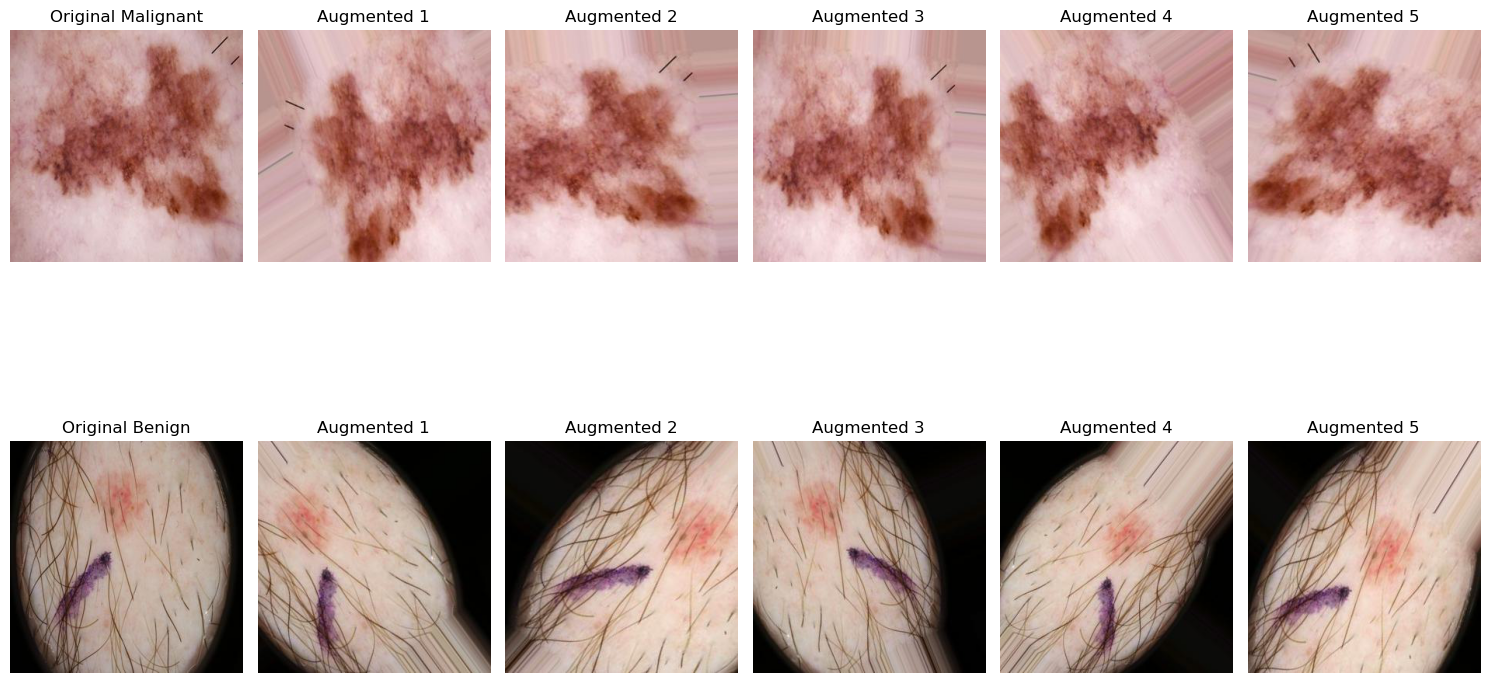

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

# Paths to the images for malignant
original_malignant_image_path = r"C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\malignant\melanoma_9492.jpg"
augmented_malignant_image_paths = [
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\malignant\aug_0_2449.jpeg",
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\malignant\aug_0_4272.jpeg",
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\malignant\aug_0_7804.jpeg",
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\malignant\aug_0_1125.jpeg",
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\malignant\aug_0_1646.jpeg"
]

# Paths to the images for benign
original_benign_image_path = r"C:\Users\HP\Downloads\melanoma_cancer_dataset_without_duplicates\train\benign\melanoma_987.jpg"
augmented_benign_image_paths = [
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\benign\aug_0_440.jpeg",
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\benign\aug_0_2226.jpeg",
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\benign\aug_0_6830.jpeg",
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\benign\aug_0_6645.jpeg",
    r"C:\Users\HP\Downloads\RGB_images_train_argumentated\benign\aug_0_8770.jpeg"
]

# Load the original images
original_malignant_image = Image.open(original_malignant_image_path)
original_benign_image = Image.open(original_benign_image_path)

# Set up the plot to display images in two rows
fig, axes = plt.subplots(2, len(augmented_malignant_image_paths) + 1, figsize=(15, 10))

# Display the original malignant image (row 1, column 1)
axes[0, 0].imshow(original_malignant_image)
axes[0, 0].set_title("Original Malignant")
axes[0, 0].axis("off")

# Display the augmented malignant images (row 1, columns 2 to 6)
for i, aug_path in enumerate(augmented_malignant_image_paths):
    aug_image = Image.open(aug_path)
    axes[0, i + 1].imshow(aug_image)
    axes[0, i + 1].set_title(f"Augmented {i + 1}")
    axes[0, i + 1].axis("off")

# Display the original benign image (row 2, column 1)
axes[1, 0].imshow(original_benign_image)
axes[1, 0].set_title("Original Benign")
axes[1, 0].axis("off")

# Display the augmented benign images (row 2, columns 2 to 6)
for i, aug_path in enumerate(augmented_benign_image_paths):
    aug_image = Image.open(aug_path)
    axes[1, i + 1].imshow(aug_image)
    axes[1, i + 1].set_title(f"Augmented {i + 1}")
    axes[1, i + 1].axis("off")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### Display the original Grey Scale and Argumented Grey Scale

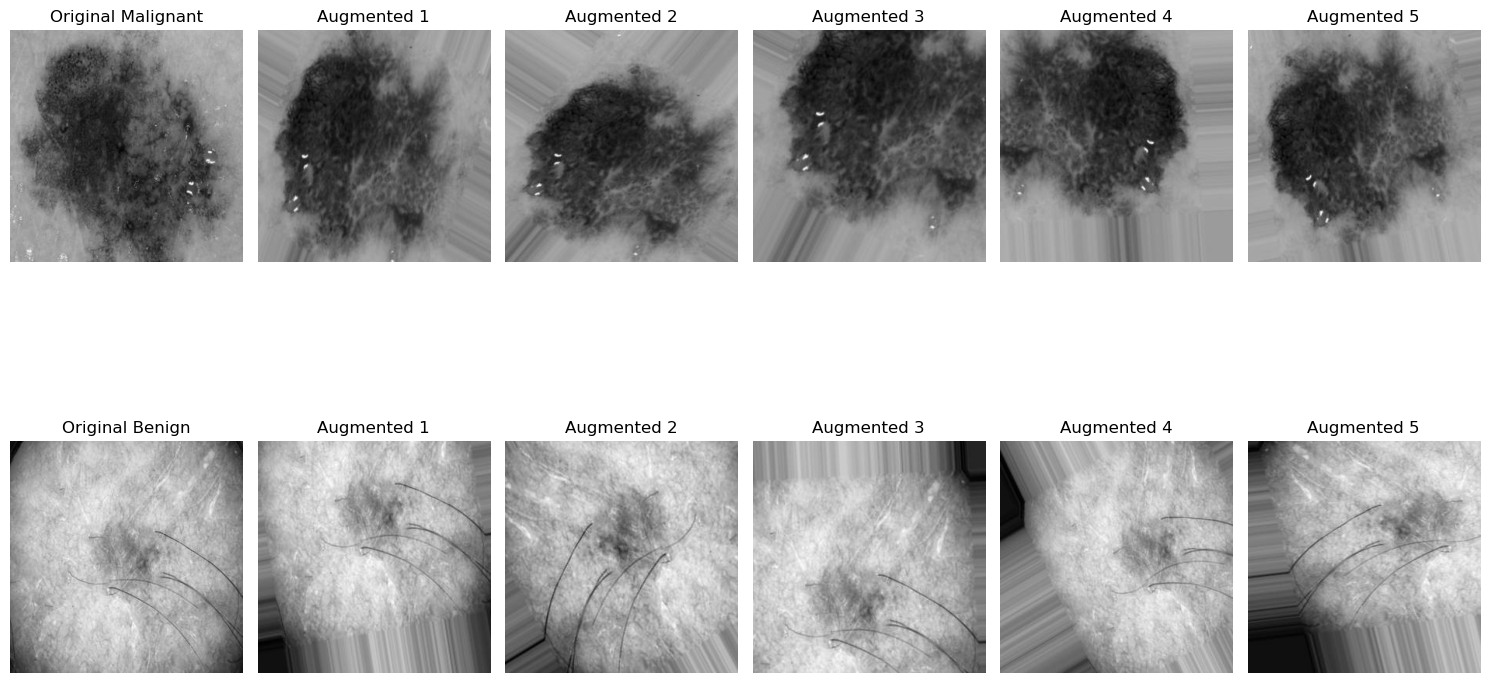

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

# Paths to the images for malignant (Grayscale)
original_malignant_image_path = r"C:\Users\HP\Downloads\Grey_images\Train\malignant\melanoma_9562.jpg"
augmented_malignant_image_paths = [
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\malignant\aug_0_9499.jpeg",
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\malignant\aug_0_4896.jpeg",
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\malignant\aug_0_5602.jpeg",
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\malignant\aug_0_4429.jpeg",
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\malignant\aug_0_6498.jpeg"
]

# Paths to the images for benign (Grayscale)
original_benign_image_path = r"C:\Users\HP\Downloads\Grey_images\Train\benign\melanoma_98.jpg"
augmented_benign_image_paths = [
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\benign\aug_0_9043.jpeg",
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\benign\aug_0_4049.jpeg",
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\benign\aug_0_5076.jpeg",
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\benign\aug_0_8625.jpeg",
    r"C:\Users\HP\Downloads\Grey_images_train_argumented\benign\aug_0_9964.jpeg"
]

# Load the original images in grayscale
original_malignant_image = Image.open(original_malignant_image_path).convert('L')
original_benign_image = Image.open(original_benign_image_path).convert('L')

# Set up the plot to display images in two rows
fig, axes = plt.subplots(2, len(augmented_malignant_image_paths) + 1, figsize=(15, 10))

# Display the original malignant image (row 1, column 1)
axes[0, 0].imshow(original_malignant_image, cmap='gray')
axes[0, 0].set_title("Original Malignant")
axes[0, 0].axis("off")

# Display the augmented malignant images (row 1, columns 2 to 6)
for i, aug_path in enumerate(augmented_malignant_image_paths):
    aug_image = Image.open(aug_path).convert('L')
    axes[0, i + 1].imshow(aug_image, cmap='gray')
    axes[0, i + 1].set_title(f"Augmented {i + 1}")
    axes[0, i + 1].axis("off")

# Display the original benign image (row 2, column 1)
axes[1, 0].imshow(original_benign_image, cmap='gray')
axes[1, 0].set_title("Original Benign")
axes[1, 0].axis("off")

# Display the augmented benign images (row 2, columns 2 to 6)
for i, aug_path in enumerate(augmented_benign_image_paths):
    aug_image = Image.open(aug_path).convert('L')
    axes[1, i + 1].imshow(aug_image, cmap='gray')
    axes[1, i + 1].set_title(f"Augmented {i + 1}")
    axes[1, i + 1].axis("off")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
